In [ ]:
!pip install -r https://raw.githubusercontent.com/datamllab/automl-in-action-notebooks/master/requirements.txt

In [2]:
import keras_tuner as kt

## Load data

In [3]:
# Import the dataset loading function from sklearn
from sklearn.datasets import load_digits

# Load the hand-written digits dataset
digits = load_digits()

# Get the images and corresponding labels
images, labels = digits.images, digits.target
images.shape, labels.shape

((1797, 8, 8), (1797,))

## Exploratory data analysis & Data preprocessing &  feature engineering

In [4]:
# reshape images to vectors
n_samples = len(images)
X = images.reshape((n_samples, -1))
X.shape

(1797, 64)

In [5]:
# Split data into train and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, shuffle=False)

print("Shape of the training data: {}".format(X_train.shape))
print("Shape of the testing data: {}".format(X_test.shape))

Shape of the training data: (1437, 64)
Shape of the testing data: (360, 64)


In [6]:
X_train.shape, X_test.shape

((1437, 64), (360, 64))

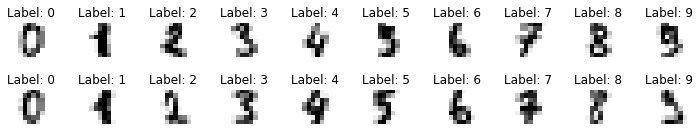

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# plot first 20 images
n = 20
_, axes = plt.subplots(2, 10, figsize=(10, 2))
plt.tight_layout()
for i in range(n):
    row, col = i // 10, i % 10
    axes[row, col].set_axis_off()
    axes[row, col].imshow(images[i,], cmap=plt.cm.gray_r, interpolation='nearest')
    axes[row, col].set_title('Label: %i' % labels[i])

## KerasTuner tuning: joint hyperparameter tuning and model selection

In [8]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras_tuner.engine import hyperparameters as hp


def build_model(hp):
    model_type = hp.Choice('model_type', ['svm', 'random_forest'])
    if model_type == 'svm':
        with hp.conditional_scope('model_type', 'svm'):
            model = SVC(C=hp.Float('C', 1e-3, 10, sampling='linear', default=1),
                        kernel=hp.Choice("kernel_type", ['linear', 'rbf'], default="linear"), 
                        random_state=42)
    elif model_type == 'random_forest':
        with hp.conditional_scope('model_type', 'random_forest'):
            model =  RandomForestClassifier(
                n_estimators=hp.Int('n_estimators', 10, 200, step=10),
                max_depth=hp.Int('max_depth', 3, 10))
    else:
        raise ValueError('Unrecognized model_type')
    return model



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  This is separate from the ipykernel package so we can avoid doing imports until


### Random Search Algorithm

In [9]:
from sklearn.model_selection import KFold
import sklearn.pipeline

random_tuner = kt.tuners.SklearnTuner(
        oracle=kt.oracles.RandomSearch(
            objective=kt.Objective('score', 'max'),
            max_trials=30,
            seed=42),
        hypermodel=build_model,
        cv=KFold(3, shuffle=True, random_state=42),
        overwrite=True,
        project_name='random_tuner')

random_tuner.search(X_train, y_train)

Trial 30 Complete [00h 00m 00s]
score: 0.9617258176757133

Best score So Far: 0.9937369519832986
Total elapsed time: 00h 00m 29s
INFO:tensorflow:Oracle triggered exit


In [10]:
random_tuner.search_space_summary()

Search space summary
Default search space size: 5
model_type (Choice)
{'default': 'svm', 'conditions': [], 'values': ['svm', 'random_forest'], 'ordered': False}
C (Float)
{'default': 1, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['svm']}}], 'min_value': 0.001, 'max_value': 10.0, 'step': None, 'sampling': 'linear'}
kernel_type (Choice)
{'default': 'linear', 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['svm']}}], 'values': ['linear', 'rbf'], 'ordered': False}
n_estimators (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['random_forest']}}], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
max_depth (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['random_forest']}}], 'min_value': 3, 'max_value': 10, 'step': 1, 'sampling': None}


In [11]:
random_tuner.results_summary(1)

Results summary
Results in ./random_tuner
Showing 1 best trials
Objective(name='score', direction='max')
Trial summary
Hyperparameters:
model_type: svm
C: 3.5191107120229987
kernel_type: rbf
Score: 0.9937369519832986


In [12]:
# Evaluate the best discovered model
from sklearn.metrics import accuracy_score

best_model = random_tuner.get_best_models(1)[0]
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print("The prediction accuracy on test set: {:.2f} %".format(test_acc * 100))

The prediction accuracy on test set: 95.83 %


## KerasTuner tuning: whole pipeline with shallow models

In [13]:
from keras_tuner.engine import hyperparameters as hp
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


def build_pipeline(hp):

    # select hyperparameters of PCA
    n_components=hp.Choice("n_components", [2, 5, 10], default=5)
    pca = PCA(n_components=n_components)

    # select model type
    model_type = hp.Choice('model_type', ['svm', 'random_forest'])
    if model_type == 'svm':
        with hp.conditional_scope('model_type', 'svm'):
            model = SVC(C=hp.Float('C', 1e-3, 10, sampling='linear', default=1),
                        kernel=hp.Choice("kernel_type", ['linear', 'rbf'], default="linear"), 
                        random_state=42)
    elif model_type == 'random_forest':
        with hp.conditional_scope('model_type', 'random_forest'):
            model =  RandomForestClassifier(
                n_estimators=hp.Int('n_estimators', 10, 200, step=10),
                max_depth=hp.Int('max_depth', 3, 10))
    else:
        raise ValueError('Unrecognized model_type')

    # create pipeline
    pipeline = Pipeline([
        ('pca', pca),
        ('clf', model)
        ])

    return pipeline

tuner = kt.tuners.Sklearn(
        oracle=kt.oracles.RandomSearch(
            objective=kt.Objective('score', 'max'),
            max_trials=3),
        hypermodel=build_pipeline,
        overwrite=True)
tuner.search(X_train, y_train)

Trial 3 Complete [00h 00m 01s]
score: 0.6499637049941929

Best score So Far: 0.7250846883468836
Total elapsed time: 00h 00m 03s
INFO:tensorflow:Oracle triggered exit


In [14]:
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name='score', direction='max')
Trial summary
Hyperparameters:
n_components: 5
model_type: random_forest
n_estimators: 10
max_depth: 3
Score: 0.7250846883468836


In [15]:
# Evaluate the best discovered model
from sklearn.metrics import accuracy_score

best_pipeline = tuner.get_best_models(1)[0]
best_pipeline.fit(X_train, y_train)
y_pred_test = best_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print("The prediction accuracy on test set: {:.2f} %".format(test_acc * 100))

The prediction accuracy on test set: 71.11 %


In [16]:
bo_tuner = kt.tuners.SklearnTuner(
        oracle=kt.oracles.BayesianOptimization(
            objective=kt.Objective('score', 'max'),
            max_trials=30,
            seed=42),
        hypermodel=build_pipeline,
        cv=KFold(3, shuffle=True, random_state=42),
        overwrite=True,
        project_name='bo_tuner')

bo_tuner.search(X_train, y_train)

Trial 30 Complete [00h 00m 00s]
score: 0.9812108559498957

Best score So Far: 0.9826026443980515
Total elapsed time: 00h 01m 37s
INFO:tensorflow:Oracle triggered exit


In [17]:
bo_tuner.search_space_summary()

Search space summary
Default search space size: 6
n_components (Choice)
{'default': 5, 'conditions': [], 'values': [2, 5, 10], 'ordered': True}
model_type (Choice)
{'default': 'svm', 'conditions': [], 'values': ['svm', 'random_forest'], 'ordered': False}
C (Float)
{'default': 1, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['svm']}}], 'min_value': 0.001, 'max_value': 10.0, 'step': None, 'sampling': 'linear'}
kernel_type (Choice)
{'default': 'linear', 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['svm']}}], 'values': ['linear', 'rbf'], 'ordered': False}
n_estimators (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['random_forest']}}], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
max_depth (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['random_forest']}}], 'min_value': 3, 'ma

In [18]:
bo_tuner.results_summary(1)

Results summary
Results in ./bo_tuner
Showing 1 best trials
Objective(name='score', direction='max')
Trial summary
Hyperparameters:
n_components: 10
model_type: svm
C: 4.085950256665684
kernel_type: rbf
Score: 0.9826026443980515


In [19]:
# Evaluate the best discovered model
from sklearn.metrics import accuracy_score

best_model = bo_tuner.get_best_models(1)[0]
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print("The prediction accuracy on test set: {:.2f} %".format(test_acc * 100))

The prediction accuracy on test set: 94.44 %


# Automated Feature Engineering

In [20]:
import tensorflow as tf

TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

In [21]:
import pandas as pd

x_train = pd.read_csv(train_file_path)
y_train = x_train.pop("survived")
y_train = pd.DataFrame(y_train)

x_test = pd.read_csv(test_file_path)
y_test = x_test.pop("survived")

x_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [22]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numerical_columns = ['age', 'fare']
one_hot_columns = ['n_siblings_spouses', 'class']
int_columns = ['sex', 'parch', 'deck', 'embark_town', 'alone']

numerical_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='median')),
  ('normalizer', StandardScaler())
])

one_hot_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
  ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

int_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
  ('label_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalCombination(BaseEstimator, TransformerMixin):
  def __init__(self, name_a, name_b):
    self.name_a = name_a
    self.name_b = name_b
    self.encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

  def fit(self, x, y=None, **kwargs):
    temp_column = x[self.name_a].astype(str) + x[self.name_b].astype(str)
    self.encoder.fit(temp_column.to_frame())
    return self

  def transform(self, x, **kwargs):
    temp_column = x[self.name_a].astype(str) + x[self.name_b].astype(str)
    temp_column = self.encoder.transform(temp_column.to_frame())
    return temp_column

In [24]:
temp_data = pd.DataFrame({
    '1': ['A', 'A', 'A', 'B', 'B', 'B'],
    '2': [1, 0, 1, 0, 1, 1]
})
print(temp_data.head(6))

   1  2
0  A  1
1  A  0
2  A  1
3  B  0
4  B  1
5  B  1


In [25]:
transformer = CategoricalCombination('1', '2')
print(transformer.fit_transform(temp_data))

[[1.]
 [0.]
 [1.]
 [2.]
 [3.]
 [3.]]


In [26]:
class MeanEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, categorical_name, numerical_name):
    self.categorical_name = categorical_name
    self.numerical_name = numerical_name
    self.means = None

  def fit(self, x, y=None, **kwargs):
    self.mean = x.groupby(self.categorical_name)[self.numerical_name].mean()
    return self

  def transform(self, x, **kwargs):
    return x[self.categorical_name].map(self.mean).to_frame()

In [27]:
temp_data = pd.DataFrame({
    'a': ['A', 'A', 'B', 'B', 'C', 'C'],
    'b': [1, 1, 1, 0, 1, -1]
})
print(temp_data.head(6))
encoder = MeanEncoder('a', 'b')
print(encoder.fit_transform(temp_data).head(6))

   a  b
0  A  1
1  A  1
2  B  1
3  B  0
4  C  1
5  C -1
     a
0  1.0
1  1.0
2  0.5
3  0.5
4  0.0
5  0.0


In [28]:
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer(transformers=[
  ('numerical', numerical_transformer, numerical_columns),
  ('one_hot', one_hot_transformer, one_hot_columns),
  ('int', int_transformer, int_columns),
  ('categorical_combination', CategoricalCombination('sex', 'class'), ['sex', 'class']),
  ('mean', MeanEncoder('embark_town', 'age'), ['embark_town', 'age'])
])

In [29]:
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

pipeline = Pipeline(steps=[
  ('preprocessing', column_transformer),
  ('feature_selection', SelectKBest(mutual_info_classif, k=8)),
  ('model', SVC()),
])
pipeline.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('normalizer',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                         

In [30]:
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(x_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.7424242424242424


In [31]:
import numpy as np

mean_column_pairs = []
for int_col in int_columns:
  for num_col in numerical_columns:
    mean_column_pairs.append((int_col, num_col))

cat_column_pairs = []
for index1 in range(len(int_columns)):
  for index2 in range(index1 + 1, len(int_columns)):
    cat_column_pairs.append((int_columns[index1], int_columns[index2]))

mean_column_pairs = np.array(mean_column_pairs)
cat_column_pairs = np.array(cat_column_pairs)

In [32]:
transformers = []
for index, (col1, col2) in enumerate(cat_column_pairs):
    if not hp.Boolean('combine_{i}'.format(i=index)):
      continue
    col1 = str(col1)
    col2 = str(col2)
    transformers.append((
        col1 + col2,
        CategoricalCombination(col1, col2),
        [col1, col2]))

In [33]:
import keras_tuner as kt

def build_model(hp):
  numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('normalizer', StandardScaler())
  ])

  one_hot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
  ])

  int_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('label_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
  ])

  transformers = [
    ('numerical', numerical_transformer, numerical_columns),
    ('one_hot', one_hot_transformer, one_hot_columns),
    ('int', int_transformer, int_columns),
  ]
  for index, (col1, col2) in enumerate(cat_column_pairs):
    if not hp.Boolean('combine_{i}'.format(i=index)):
      continue
    col1 = str(col1)
    col2 = str(col2)
    transformers.append((
        col1 + col2,
        CategoricalCombination(col1, col2),
        [col1, col2]))

  for index, (col1, col2) in enumerate(mean_column_pairs):
    if not hp.Boolean('mean_{i}'.format(i=index)):
      continue
    col1 = str(col1)
    col2 = str(col2)
    transformers.append((
        col1 + col2,
        MeanEncoder(col1, col2),
        [col1, col2]))
  print(transformers)
  pipeline = Pipeline(steps=[
    ('preprocessing', ColumnTransformer(transformers=transformers)),
    ('impute', SimpleImputer(strategy='median')),
    ('model_selection', SelectKBest(
        mutual_info_classif,
        k=hp.Int('best_k',
                 5,
                 13 + len(transformers) - 3))),
    ('model', SVC()),
  ])

  return pipeline

In [34]:
build_model(kt.HyperParameters()).fit(x_train, y_train)

[('numerical', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('normalizer', StandardScaler())]), ['age', 'fare']), ('one_hot', Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='None', strategy='constant')),
                ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]), ['n_siblings_spouses', 'class']), ('int', Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='None', strategy='constant')),
                ('label_encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1))]), ['sex', 'parch', 'deck', 'embark_town', 'alone'])]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('normalizer',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                         

In [35]:
from sklearn import metrics
import sklearn

tuner = kt.SklearnTuner(
    kt.oracles.RandomSearchOracle(
        objective=kt.Objective('score', 'max'),
        max_trials=10,
    ),
    build_model,
    scoring=metrics.make_scorer(metrics.accuracy_score),
    overwrite=True,
)
tuner.search(x_train, y_train)

Trial 10 Complete [00h 00m 00s]
score: 0.8053587301587302

Best score So Far: 0.8101460317460317
Total elapsed time: 00h 00m 11s
INFO:tensorflow:Oracle triggered exit
